In [1]:
from ica_benchmark.io.load import OpenBMI_Dataset
from pathlib import Path
import pandas as pd
from mne.decoding import CSP
import numpy as np

In [2]:
from sklearn.base import BaseEstimator
from mne.time_frequency import psd_array_welch, psd_welch
import numpy as np
import mne

class ConcatenateChannelsPSD(BaseEstimator):
    def __init__(self):
        super(ConcatenateChannelsPSD).__init__()

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        n = len(x)
        return x.reshape(n, -1)


class GetEpochsData(BaseEstimator):
    def __init__(self):
        super(GetEpochsData).__init__()

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        return x.get_data()


class PSD(BaseEstimator):
    BANDS_DICT = {
    #         "delta": (1, 4),
    #         "theta": (4, 8),
    #         "mu": (8, 13),
        "mu": (8, 13),
    #         "beta": (13, 25),
        "beta": (13, 25),
    #         "gamma": (25, 40)
    }
    def __init__(self, **kwargs):
        super(PSD).__init__()
        self.kwargs = kwargs

    def set_params(**params):
        for param in params:
            assert params in ["picks", "n_fft", "n_overlap", "n_per_seg"]
        self.kwargs.update(params)

    def get_params(self, *args, **kwargs):
        return self.kwargs

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        if isinstance(x, list):
            x = mne.concatenate_epochs(x)
            psds, freqs = psd_welch(x, ** self.kwargs)
        if isinstance(x, mne.Epochs):
    #             psds, freqs = psd_welch(x, ** self.kwargs)
            x = x.get_data()
        if isinstance(x, np.ndarray):
            psds, freqs = psd_array_welch(x, ** self.kwargs)
        if ("average" in self.kwargs) and (self.kwargs["average"] is None):
            psds = psds.sum(axis=3)
        self.freqs = freqs

        band_spectras = list()
        for band, (lfreq, hfreq) in self.BANDS_DICT.items():
            band_spectra = psds[:, :, (freqs >= lfreq) & (freqs < hfreq)]
            band_spectras.append(
                band_spectra.sum(axis=2, keepdims=True)
            )

        band_spectras = np.concatenate(band_spectras, axis=2)

        return band_spectras

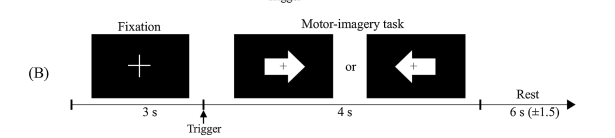

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import cohen_kappa_score, balanced_accuracy_score
import mne
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

mne.set_log_level(False)

channels = ["FC" + str(s) for s in [5, 3, 1, 2, 4, 6]]
channels += ["C" + str(s) for s in [5, 3, 1, 2, 4, 6]]
channels += ["CP" + str(s) for s in [5, 3, 1, 2, 4, 6]]


filter_kwargs = dict(
    method="iir",
    iir_params=dict(
        order=5,
        ftype="butter"
    )
)

def run_experiment(train_epochs, test_epochs):

    train_epochs = train_epochs.copy()
    test_epochs = test_epochs.copy()
    
    train_epochs.load_data()
    test_epochs.load_data()

#     train_epochs = train_epochs.apply_baseline().pick(channels).filter(8, 30, **filter_kwargs)
#     test_epochs = test_epochs.apply_baseline().pick(channels).filter(8, 30, **filter_kwargs)
    train_epochs = train_epochs.pick(channels).filter(8, 30, **filter_kwargs)
    test_epochs = test_epochs.pick(channels).filter(8, 30, **filter_kwargs)
    
    x_train = train_epochs.get_data()
    x_test = test_epochs.get_data()
    y_train = train_epochs.events[:, 2]
    y_test = test_epochs.events[:, 2]
    
    csp = CSP(n_components=len(channels) // 2, log=True)
    csp.fit(x_train, y_train)

    x_train = csp.transform(x_train)
    x_test = csp.transform(x_test)

    lr = LinearDiscriminantAnalysis().fit(x_train, y_train)
    
    predictions = lr.predict(x_test)
    
    acc = balanced_accuracy_score(y_test, predictions)
    return acc

In [4]:
import pandas as pd
from sklearn.model_selection import KFold
from warnings import warn, filterwarnings
import numpy as np
from mne import Epochs
import mne
from ica_benchmark.io.load import OpenBMI_Dataset
from pathlib import Path
from ica_benchmark.utils.itertools import group_iterator, constrained_group_iterator
from ica_benchmark.split.split import Split, Splitter
from warnings import filterwarnings
from tqdm import tqdm

filterwarnings("ignore", category=RuntimeWarning)

openbmi_dataset_folderpath = Path('/home/paulo/Documents/datasets/OpenBMI/edf/')
dataset = OpenBMI_Dataset(openbmi_dataset_folderpath)
fold_sizes = None
splitter = Splitter(
    dataset,
    uids=dataset.list_uids()[:12],
    sessions=dataset.SESSIONS,
    runs=dataset.RUNS,
    load_kwargs=dict(
        reject=False,
        tmin=1,
        tmax=3.5
    ),
    splitter=KFold(4),
    intra_session_shuffle=True,
    fold_sizes=fold_sizes
)


results_dict = dict()

# mode = "inter_subject"
# print(mode.upper())
# splits_iterable = splitter.yield_splits_epochs(mode=mode)
# results = list()
# for i, (train_split, test_split) in enumerate(splits_iterable):
#     train_epochs, test_epochs = splitter.load_from_splits((train_split, test_split), fold_sizes=fold_sizes)
#     acc = run_experiment(train_epochs, test_epochs)
#     results.append(
#         dict(
#             mode=mode,
#             train_uids=np.unique(train_split["uid"]),
#             test_uids=np.unique(test_split["uid"]),
#             accuracy=acc
#         )
#     )
#     del train_epochs, test_epochs
# results_dict[mode] = pd.DataFrame.from_records(results)
# display(results_dict[mode])
    
print("Changing splitter uids to all")
splitter.uids = dataset.list_uids()

mode = "inter_session"
print(mode.upper())
results = list()
for sessions in [[2, 1], [1, 2]]:
    splitter.sessions = sessions
    splits_iterable = splitter.yield_splits_epochs(mode=mode)
    for i, (train_split, test_split) in enumerate(splits_iterable):
        print(train_split)
        train_epochs, test_epochs = splitter.load_from_splits((train_split, test_split), fold_sizes=fold_sizes)
        acc = run_experiment(train_epochs, test_epochs)
        results.append(
            dict(
                mode=mode,
                train_uid=np.unique(train_split["uid"]),
                train_session=np.unique(train_split["session"]),
                train_run=np.unique(train_split["run"]),
                test_uid=np.unique(test_split["uid"]),
                test_session=np.unique(test_split["session"]),
                test_run=np.unique(test_split["run"]),
                accuracy=acc
            )
        )
        del train_epochs, test_epochs
results_dict[mode] = pd.DataFrame.from_records(results)
display(results_dict[mode])


mode = "intra_session_inter_run"
print(mode.upper())
results = list()
for runs in [[2, 1], [1, 2]]:
    splitter.runs = runs
    splits_iterable = splitter.yield_splits_epochs(mode=mode)
    for i, (train_split, test_split) in enumerate(splits_iterable):
        train_epochs, test_epochs = splitter.load_from_splits((train_split, test_split), fold_sizes=fold_sizes)
        acc = run_experiment(train_epochs, test_epochs)
        results.append(
            dict(
                mode=mode,
                train_uid=np.unique(train_split["uid"]),
                train_session=np.unique(train_split["session"]),
                train_run=np.unique(train_split["run"]),
                test_uid=np.unique(test_split["uid"]),
                test_session=np.unique(test_split["session"]),
                test_run=np.unique(test_split["run"]),
                accuracy=acc
            )
        )
        del train_epochs, test_epochs
results_dict[mode] = pd.DataFrame.from_records(results)
display(results_dict[mode])


mode = "intra_session_intra_run"
print(mode.upper())
splits_iterable = splitter.yield_splits_epochs(mode=mode)
results = list()
for i, splits in enumerate(splits_iterable):
    split = splits[0]
    for trial_n in range(5):
        train_epochs, test_epochs = splitter.load_from_splits(splits, fold_sizes=[.75, .25])
        acc = run_experiment(train_epochs, test_epochs)
        results.append(
            dict(
                mode=mode,
                exp_number=trial_n,
                uid=np.unique(split["uid"]),
                session=np.unique(split["session"]),
                run=np.unique(split["run"]),
                accuracy=acc
            )
        )
        del train_epochs, test_epochs
results_dict[mode] = pd.DataFrame.from_records(results)
display(results_dict[mode])

mode = "intra_session_intra_run_merged"
print(mode.upper())
splits_iterable = splitter.yield_splits_epochs(mode=mode)
results = list()
for i, splits in enumerate(splits_iterable):
    split = splits[0]
    for trial_n in range(5):
        train_epochs, test_epochs = splitter.load_from_splits(splits, fold_sizes=[.75, .25])
        acc = run_experiment(train_epochs, test_epochs)
        results.append(
            dict(
                mode=mode,
                exp_number=trial_n,
                uid=np.unique(split["uid"]),
                session=np.unique(split["session"]),
                run=np.unique(split["run"]),
                accuracy=acc
            )
        )
        del train_epochs, test_epochs
results_dict[mode] = pd.DataFrame.from_records(results)
display(results_dict[mode])

Changing splitter uids to all
INTER_SESSION
Split({'uid': '25', 'session': 2, 'run': 1},{'uid': '25', 'session': 2, 'run': 2})
Split({'uid': '15', 'session': 2, 'run': 1},{'uid': '15', 'session': 2, 'run': 2})
Split({'uid': '41', 'session': 2, 'run': 1},{'uid': '41', 'session': 2, 'run': 2})
Split({'uid': '12', 'session': 2, 'run': 1},{'uid': '12', 'session': 2, 'run': 2})
Split({'uid': '37', 'session': 2, 'run': 1},{'uid': '37', 'session': 2, 'run': 2})
Split({'uid': '2', 'session': 2, 'run': 1},{'uid': '2', 'session': 2, 'run': 2})
Split({'uid': '42', 'session': 2, 'run': 1},{'uid': '42', 'session': 2, 'run': 2})
Split({'uid': '6', 'session': 2, 'run': 1},{'uid': '6', 'session': 2, 'run': 2})
Split({'uid': '52', 'session': 2, 'run': 1},{'uid': '52', 'session': 2, 'run': 2})
Split({'uid': '18', 'session': 2, 'run': 1},{'uid': '18', 'session': 2, 'run': 2})
Split({'uid': '38', 'session': 2, 'run': 1},{'uid': '38', 'session': 2, 'run': 2})
Split({'uid': '30', 'session': 2, 'run': 1},{'u

Split({'uid': '40', 'session': 1, 'run': 1},{'uid': '40', 'session': 1, 'run': 2})
Split({'uid': '47', 'session': 1, 'run': 1},{'uid': '47', 'session': 1, 'run': 2})
Split({'uid': '26', 'session': 1, 'run': 1},{'uid': '26', 'session': 1, 'run': 2})
Split({'uid': '49', 'session': 1, 'run': 1},{'uid': '49', 'session': 1, 'run': 2})
Split({'uid': '54', 'session': 1, 'run': 1},{'uid': '54', 'session': 1, 'run': 2})
Split({'uid': '43', 'session': 1, 'run': 1},{'uid': '43', 'session': 1, 'run': 2})
Split({'uid': '1', 'session': 1, 'run': 1},{'uid': '1', 'session': 1, 'run': 2})
Split({'uid': '3', 'session': 1, 'run': 1},{'uid': '3', 'session': 1, 'run': 2})
Split({'uid': '48', 'session': 1, 'run': 1},{'uid': '48', 'session': 1, 'run': 2})


,mode,train_uid,train_session,train_run,test_uid,test_session,test_run,accuracy
0,inter_session,[25],[2],"[1, 2]",[25],[1],"[1, 2]",0.590
1,inter_session,[15],[2],"[1, 2]",[15],[1],"[1, 2]",0.490
2,inter_session,[41],[2],"[1, 2]",[41],[1],"[1, 2]",0.585
3,inter_session,[12],[2],"[1, 2]",[12],[1],"[1, 2]",0.510
4,inter_session,[37],[2],"[1, 2]",[37],[1],"[1, 2]",0.950
...,...,...,...,...,...,...,...,...
103,inter_session,[54],[1],"[1, 2]",[54],[2],"[1, 2]",0.560
104,inter_session,[43],[1],"[1, 2]",[43],[2],"[1, 2]",0.605
105,inter_session,[1],[1],"[1, 2]",[1],[2],"[1, 2]",0.730
106,inter_session,[3],[1],"[1, 2]",[3],[2],"[1, 2]",0.945


INTRA_SESSION_INTER_RUN


,mode,train_uid,train_session,train_run,test_uid,test_session,test_run,accuracy
0,intra_session_inter_run,[25],[1],[2],[25],[1],[1],0.53
1,intra_session_inter_run,[25],[2],[2],[25],[2],[1],0.61
2,intra_session_inter_run,[15],[1],[2],[15],[1],[1],0.57
3,intra_session_inter_run,[15],[2],[2],[15],[2],[1],0.67
4,intra_session_inter_run,[41],[1],[2],[41],[1],[1],0.62
...,...,...,...,...,...,...,...,...
211,intra_session_inter_run,[1],[2],[1],[1],[2],[2],0.83
212,intra_session_inter_run,[3],[1],[1],[3],[1],[2],0.89
213,intra_session_inter_run,[3],[2],[1],[3],[2],[2],0.89
214,intra_session_inter_run,[48],[1],[1],[48],[1],[2],0.48


INTRA_SESSION_INTRA_RUN


,mode,exp_number,uid,session,run,accuracy
0,intra_session_intra_run,0,[25],[1],[1],0.496753
1,intra_session_intra_run,1,[25],[1],[1],0.487013
2,intra_session_intra_run,2,[25],[1],[1],0.516026
3,intra_session_intra_run,3,[25],[1],[1],0.554487
4,intra_session_intra_run,4,[25],[1],[1],0.391026
...,...,...,...,...,...,...
1075,intra_session_intra_run,0,[48],[2],[2],0.766667
1076,intra_session_intra_run,1,[48],[2],[2],0.766667
1077,intra_session_intra_run,2,[48],[2],[2],0.676282
1078,intra_session_intra_run,3,[48],[2],[2],0.762821


INTRA_SESSION_INTRA_RUN_MERGED


,mode,exp_number,uid,session,run,accuracy
0,intra_session_intra_run_merged,0,[25],[1],"[1, 2]",0.523349
1,intra_session_intra_run_merged,1,[25],[1],"[1, 2]",0.596059
2,intra_session_intra_run_merged,2,[25],[1],"[1, 2]",0.684729
3,intra_session_intra_run_merged,3,[25],[1],"[1, 2]",0.540064
4,intra_session_intra_run_merged,4,[25],[1],"[1, 2]",0.578526
...,...,...,...,...,...,...
535,intra_session_intra_run_merged,0,[48],[2],"[1, 2]",0.454545
536,intra_session_intra_run_merged,1,[48],[2],"[1, 2]",0.697262
537,intra_session_intra_run_merged,2,[48],[2],"[1, 2]",0.581169
538,intra_session_intra_run_merged,3,[48],[2],"[1, 2]",0.380131


In [5]:
for k, v in results_dict.items():
    if isinstance(v, list):
        results_dict[k] = pd.DataFrame.from_records(v)

In [6]:
from pathlib import Path

save_folder = Path("./splitting_results")
save_folder.mkdir(exist_ok=True)

for k, v in results_dict.items():
    results_dict[k].to_csv(save_folder / f"{k}.csv", index=False)

In [7]:
df = results_dict["inter_session"].applymap(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) == 1 else x)
for train_session in [1, 2]:
    print(
        df.query("train_session == @train_session").accuracy.mean()
    )


0.6446296296296296
0.6487037037037034


In [8]:
from itertools import product
df = results_dict["intra_session_inter_run"].applymap(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) == 1 else x)

for train_session, train_run in product([1, 2], [1, 2]):
    print("Session: {}, Run: {}".format(train_session, train_run))
    print(
        df.query("(train_session == @train_session) & (train_run == @train_run)").accuracy.mean()
    )
    print()

Session: 1, Run: 1
0.667037037037037

Session: 1, Run: 2
0.6446296296296297

Session: 2, Run: 1
0.685925925925926

Session: 2, Run: 2
0.6768518518518519



In [9]:
from itertools import product
df = results_dict["intra_session_intra_run"].applymap(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) == 1 else x)

for session, run in product([1, 2], [1, 2]):
    print("Session: {}, Run: {}".format(session, run))
    print(
        df.query("(session == @session) & (run == @run)").accuracy.mean()
    )
    print()

Session: 1, Run: 1
0.7050646928846104

Session: 1, Run: 2
0.7066333578351982

Session: 2, Run: 1
0.702635418154639

Session: 2, Run: 2
0.7369598127604663



In [10]:
from itertools import product
df = results_dict["intra_session_intra_run_merged"].applymap(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) == 1 else x)
df
for session in [1, 2]:
    print("Session: {}".format(session))
    print(
        df.query("(session == @session)").accuracy.mean()
    )
    print()

Session: 1
0.7100825844402285

Session: 2
0.7214952214862153

